In [1]:
from pytorch_transformers import BertModel, BertTokenizer, BertConfig

In [2]:
import pandas as pd
import numpy as np
import json
import os
import sys
import time
from tqdm import tqdm
import seaborn as sns; 
import matplotlib.pyplot as plt
from collections import defaultdict

### Input Example

In [3]:
# sentence_a = "To attach magnets to a piece of wood, you can"
# options = ["Use superglue","a soldering iron"]
goldlabel = "1"

In [4]:
sentence_a = 'Neatly wrap up an extension cord.'
options = ['Wrap the cord around your hand and elbow.', 'Wrap the cord around your hand and knee.']
# sentence_a = 'How to clean blinds without tearing them up'
# options = ['Place a cloth on each side of a pair of tongs.', 'Find a feather duster, and cut the feathers off every two inches.']

In [5]:
data={}
data['id']= "1"
data["question"]= ""
data["premises"] = [[sentence_a],[sentence_a]]
data["choices"]= options
data["gold_label"]= goldlabel


### Utility Functions

In [6]:
import torch
def get_proba(logits):
    m = torch.nn.Softmax(dim=1)
    return m(logits)
    

In [7]:
def get_tokens(tokens):
    ''' Get the token words from tokenids tensor '''
    
    tokens = tokens.numpy().reshape(tokens.size()[1],-1)
    num_choices = len(tokens)
    token_words = {}
    for idx, each in enumerate(tokens):
        each_choice_words = []
        for each_word in each:
            if each_word != tokenizer._convert_token_to_id("[PAD]"):
                each_choice_words.append(tokenizer._convert_id_to_token(each_word))
        token_words['choice'+str(idx)] = each_choice_words
        
    return token_words
        

### Load McQueen Models

In [8]:
sys.path.append("../models")
from hf_bert_mcq_parallel_reader import BertMCQParallelReader
from hf_bert_mcq_parallel import BertMCQParallel
from util import cleanup_global_logging,prepare_global_logging
from hf_bert_mcq_concat import BertMCQConcat
from hf_bert_mcq_concat_reader import BertMCQConcatReader
from hf_bert_mcq_weighted_sum import BertMCQWeightedSum
from hf_bert_mcq_simple_sum import BertMCQSimpleSum
from hf_bert_mcq_mac import BertMCQMAC
from pytorch_transformers.file_utils import PYTORCH_PRETRAINED_BERT_CACHE

### Input McQueen Params

In [9]:
model_type = 'bert'
model_version = 'bert-large-uncased-whole-word-masking'
mcq_model = 'bert-mcq-weighted-sum'
tie_weights_weighted_sum = True
local_rank = 0
do_lower_case = True
max_len = 128
model_dir = "/scratch/kkpal/physical/noq/tiedws_128_9e-6_10865"
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

09/26/2019 15:26:21 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-vocab.txt from cache at /home/kkpal/.cache/torch/pytorch_transformers/b3a6b2c6d7ea2ffa06d0e7577c1e88b94fad470ae0f060a4ffef3fe0bdf86730.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


### Input Visualization Params

In [10]:
sent_type = 'ab' #[possible values 'all', 'aa', 'ab', 'ba', 'bb']
layer, head = 1,4 #[Bert-large: layerno:0-23, heads:0-15]

### Model & DataReader selection

In [11]:
if mcq_model == 'bert-mcq-parallel-max':
    model = BertMCQParallel.from_pretrained(model_dir,output_attentions=True,
                                            cache_dir=os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE),
                                                                   'distributed_{}'.format(local_rank)))
    data_reader = BertMCQParallelReader()
elif mcq_model == 'bert-mcq-concat':
    model = BertMCQConcat.from_pretrained(model_dir,output_attentions=True,
                                            cache_dir=os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE),
                                                                   'distributed_{}'.format(local_rank)))
    data_reader = BertMCQConcatReader()
elif mcq_model == 'bert-mcq-weighted-sum':
    model = BertMCQWeightedSum.from_pretrained(model_dir,output_attentions=True,
                                               tie_weights = tie_weights_weighted_sum,
                                               cache_dir=os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE),
                                                                      'distributed_{}'.format(local_rank)))
    data_reader = BertMCQParallelReader()
elif mcq_model == 'bert-mcq-simple-sum':
    model = BertMCQSimpleSum.from_pretrained(model_dir,output_attentions=True,
                                             cache_dir=os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE),
                                                                      'distributed_{}'.format(local_rank)))
    data_reader = BertMCQParallelReader()
elif mcq_model == 'bert-mcq-mac':
    model = BertMCQMAC.from_pretrained(model_dir,output_attentions=True,
                                               cache_dir=os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE),
                                                                      'distributed_{}'.format(local_rank)))
    data_reader = BertMCQParallelReader()
else:
    print ("Model Unknown")

09/26/2019 15:26:22 - INFO - pytorch_transformers.modeling_utils -   loading configuration file /scratch/kkpal/physical/noq/tiedws_128_9e-6_10865/config.json
09/26/2019 15:26:22 - INFO - pytorch_transformers.modeling_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 2,
  "output_attentions": true,
  "output_hidden_states": false,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

09/26/2019 15:26:22 - INFO - pytorch_transformers.modeling_utils -   loading weights file /scratch/kkpal/physical/noq/tiedws_128_9e-6_10865/pytorch_model.bin


### DataLoader of McQueen Models
* Prepare an example data
* Get the string 

In [12]:
!rm cached_bert_example.json_128_None
with open('example.json', 'w') as fp:
    json.dump(data, fp)

### McQueen Evaluation

In [13]:
def visualize_attention_heads(X1, X2, sent_type, layer, head):
    ''' Visualize the attention heads in headmaps for a given layer and head '''
    sns.set()
    sns.set(rc={'figure.figsize':(20,5)})

#     print (np.asarray(X1[sent_type]['attn']).shape)
    data1 = np.asarray(X1[sent_type]['attn'])[layer][head]
    data2 = np.asarray(X2[sent_type]['attn'])[layer][head]
    
    xticks1 = X1[sent_type]['right_text']
    yticks1 = X1[sent_type]['left_text']
    xticks2 = X2[sent_type]['right_text']
    yticks2 = X2[sent_type]['left_text']
    
    f,(ax1,ax2) = plt.subplots(1,2)

#     ax1.get_shared_y_axes().join(ax2)
    ax1.xaxis.tick_top()
    ax2.xaxis.tick_top()
    ax1.set_title("Attention: Choice0")
    ax2.set_title("Attention: Choice1")
    g1 = sns.heatmap(data1,cbar=True,annot=False,ax=ax1,xticklabels=xticks1,yticklabels=yticks1)
    g1.set_ylabel('')
    g1.set_xlabel('')
    g2 = sns.heatmap(data2,cbar=True,annot=False,ax=ax2,xticklabels=xticks2,yticklabels=yticks2)
    g2.set_ylabel('')
    g2.set_xlabel('')
    
    
    # ax = sns.heatmap(uniform_data, vmin=0, vmax=1,annot=True, fmt="f",cmap="YlGnBu",xticklabels=X['ab']['right_text'][::-1],yticklabels=X['ab']['left_text'])
#     ax = sns.heatmap(data, annot=False, xticklabels=X[sent]['right_text'],yticklabels=X[sent]['left_text'])

In [14]:
def format_attention(attention, tokens, include_queries_and_keys=False):
    ''' Process the attentions data'''
    
    is_sentence_pair = True
    if is_sentence_pair:
        slice_a = slice(0, tokens.index("[SEP]")+1)            # Position corresponding to sentence A in input
        slice_b = slice(tokens.index("[SEP]")+1, len(tokens))  # Position corresponding to sentence B in input
        slice_ab = slice(0, len(tokens))                       # Position corresponding to sentence AB in input
    # Populate map with attn data and, optionally, query, key data
    attn_dict = defaultdict(list)
    if include_queries_and_keys:
        queries_dict = defaultdict(list)
        keys_dict = defaultdict(list)

    for layer, attn_data in enumerate(attention):
        attn = attn_data  # [16,128,128] assume batch_size=1; shape = [num_heads, source_seq_len, target_seq_len]
        attn_dict['all'].append(attn[:, slice_ab, slice_ab].tolist())
        if is_sentence_pair:
            attn_dict['aa'].append(attn[:, slice_a, slice_a].tolist())  # Append A->A attention for layer, across all heads
            attn_dict['bb'].append(attn[:, slice_b, slice_b].tolist())  # Append B->B attention for layer, across all heads
            attn_dict['ab'].append(attn[:, slice_a, slice_b].tolist())  # Append A->B attention for layer, across all heads
            attn_dict['ba'].append(attn[:, slice_b, slice_a].tolist())  # Append B->A attention for layer, across all heads
        # Process queries and keys
        if include_queries_and_keys:
            queries = attn_data['queries'][0]  # assume batch_size=1; shape = [num_heads, seq_len, vector_size]
            keys = attn_data['keys'][0]  # assume batch_size=1; shape = [num_heads, seq_len, vector_size]
            queries_dict['all'].append(queries.tolist())
            keys_dict['all'].append(keys.tolist())
            if is_sentence_pair:
                queries_dict['a'].append(queries[:, slice_a, :].tolist())
                keys_dict['a'].append(keys[:, slice_a, :].tolist())
                queries_dict['b'].append(queries[:, slice_b, :].tolist())
                keys_dict['b'].append(keys[:, slice_b, :].tolist())
    tokens_a = tokens[slice_a]
    tokens_b = tokens[slice_b]
    results = {
            'all': {
                'attn': attn_dict['all'],
                'left_text': tokens_a + (tokens_b if tokens_b else []),
                'right_text': tokens_a + (tokens_b if tokens_b else [])
            }
        }
    if is_sentence_pair:
        results.update({
            'aa': {
                'attn': attn_dict['aa'],
                'left_text': tokens_a,
                'right_text': tokens_a
            },
            'bb': {
                'attn': attn_dict['bb'],
                'left_text': tokens_b,
                'right_text': tokens_b
            },
            'ab': {
                'attn': attn_dict['ab'],
                'left_text': tokens_a,
                'right_text': tokens_b
            },
            'ba': {
                'attn': attn_dict['ba'],
                'left_text': tokens_b,
                'right_text': tokens_a
            }
        })

    return results

In [15]:
print (list(model._weight_layer.parameters()))

[Parameter containing:
tensor([[ 0.0088,  0.0278,  0.0152,  ..., -0.0057,  0.0002,  0.0003]],
       requires_grad=True), Parameter containing:
tensor([-0.0008], requires_grad=True)]


In [17]:
print (list(model._classification_layer.parameters()))

[Parameter containing:
tensor([[ 0.0088,  0.0278,  0.0152,  ..., -0.0057,  0.0002,  0.0003]],
       requires_grad=True), Parameter containing:
tensor([-0.0008], requires_grad=True)]


### Extract the Attentions and Output

09/26/2019 15:26:35 - INFO - hf_bert_mcq_parallel_reader -   Reading MCQ instances for 'bert mcq parallel' from jsonl dataset at: example.json
preparing dataset:: 1it [00:00, 902.58it/s]
09/26/2019 15:26:35 - INFO - hf_bert_mcq_parallel_reader -   Truncated Pairs:0


pooled_ph: torch.Size([2, 1024])
pooled_ph-> torch.Size([2, 1, 1024])
weights: [[1.0], [1.0]]
torch.Size([2, 1])
weighted: torch.Size([2, 1024])
logits: torch.Size([2, 1])
ProbA: [0.5722852945327759]
ProbB: [0.4277147650718689]
Gold: 1
Logits: [[-2.494601 -2.785782]]
Predicted: 0
Wrong


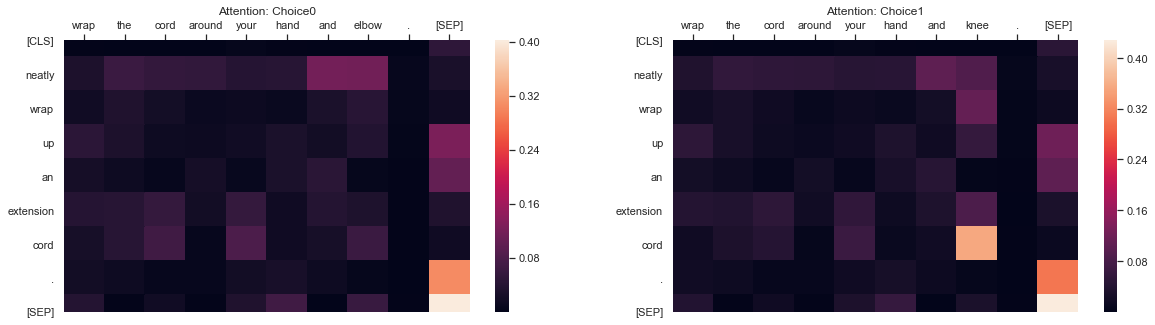

In [19]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler)
eval_data = data_reader.read("example.json", tokenizer, max_len)
eval_dataloader = DataLoader(eval_data,batch_size=1)

for input_ids, segment_ids, input_mask,label_ids in eval_dataloader:

    tokens = get_tokens(input_ids)
    outputs, attn = model(input_ids, segment_ids, input_mask, label_ids)
    
    # ----------- 1. Visualize the attention heads ----------- #
    
    full_attn = torch.Tensor()
    
    for e in attn:
        full_attn = torch.cat((full_attn,e[None,:,:,:,:]))
    
    
    # Get attentions corresponding to Choice 0 and Choice 1
    X1 = format_attention(full_attn[:,0,:,:], tokens['choice0']) # Shape (layer,head,src_max_len,tgt_max_len) for choice0
    X2 = format_attention(full_attn[:,1,:,:], tokens['choice1']) # Shape (layer,head,src_max_len,tgt_max_len) for choice1

    visualize_attention_heads(X1, X2, sent_type,layer, head)
    
    
    # ----------- 2. Choice Prediction and Probabilities ----------- #
    
    tmp_eval_loss = outputs[0]
    logits = outputs[1]
    p = get_proba(logits).detach().cpu()

    print ("ProbA:",p[:,0].numpy().tolist())
    print ("ProbB:",p[:,1].numpy().tolist())

    logits = logits.detach().cpu().numpy()
    label_ids = label_ids.to('cpu').numpy()[0]
    print ("Gold:",label_ids)
    print ("Logits:",logits)
    outputs = np.argmax(logits, axis=1)[0]
    print ("Predicted:",outputs)
    print ("Correct" if outputs==label_ids else "Wrong")
